# Maize Leaf Classification: Fall Armyworm vs Healthy

This notebook implements a binary classification model to distinguish between healthy maize leaves and those affected by fall armyworm using transfer learning with PyTorch.

## Project Overview
- **Task**: Binary classification (0: Healthy, 1: Fall Armyworm)
- **Model**: EfficientNet-B0 with transfer learning
- **Framework**: PyTorch
- **Metrics**: Loss, Accuracy, AUC-ROC

## 1. Environment Setup and Imports

## Kaggle Environment Setup

This notebook is configured to run on Kaggle with the following directory structure:
- **Input Data**: `/kaggle/input/somalia-hackerthon/Somalia/`
- **Output Files**: `/kaggle/working/` (for model and submission files)

The dataset should be attached as a Kaggle dataset named "somalia-hackerthon".

In [1]:
# Environment detection and path setup
import os

# Check if running on Kaggle
is_kaggle = os.path.exists('/kaggle')

if is_kaggle:
    print("✅ Running on Kaggle")
    # Kaggle paths
    DATA_DIR = '/kaggle/input/somalia-hackerthon/Somalia'
    OUTPUT_DIR = '/kaggle/working'
else:
    print("⚠️  Running locally - using local paths")
    # Local paths (fallback)
    DATA_DIR = '.'
    OUTPUT_DIR = '.'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# Verify paths exist
if os.path.exists(DATA_DIR):
    print(f"✅ Data directory exists")
    if os.path.exists(os.path.join(DATA_DIR, 'Images')):
        print(f"✅ Images directory found")
    else:
        print(f"❌ Images directory not found")
else:
    print(f"❌ Data directory not found: {DATA_DIR}")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Output directory ready: {OUTPUT_DIR}")

✅ Running on Kaggle
Data directory: /kaggle/input/somalia-hackerthon/Somalia
Output directory: /kaggle/working
✅ Data directory exists
✅ Images directory found
✅ Output directory ready: /kaggle/working


In [2]:
# Install required packages
!pip install timm tqdm scikit-learn matplotlib seaborn pillow torch torchvision

# Note: Run this cell first, then restart the kernel if needed before running the next cell
print("Packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [3]:
# Alternative: Install packages one by one if the above fails
# Uncomment and run these lines if needed:

# !pip install torch torchvision
# !pip install timm
# !pip install matplotlib seaborn
# !pip install scikit-learn
# !pip install pillow
# !pip install tqdm

# Verify installations
try:
    import torch
    import torchvision
    import timm
    import matplotlib
    import seaborn
    import sklearn
    import PIL
    import tqdm
    print("✅ All packages are available!")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Torchvision version: {torchvision.__version__}")
    print(f"TIMM version: {timm.__version__}")
except ImportError as e:
    print(f"❌ Missing package: {e}")

✅ All packages are available!
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
TIMM version: 1.0.15


In [4]:
# Import libraries with fallback installation
import os
import random
import numpy as np
import pandas as pd

# Try importing matplotlib, install if missing
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("Installing missing visualization packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns

from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports with fallback
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    import timm
except ImportError:
    print("Installing missing PyTorch packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "timm"])
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    import timm

# Sklearn imports with fallback
try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
except ImportError:
    print("Installing scikit-learn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Progress bar with fallback
try:
    from tqdm import tqdm
except ImportError:
    print("Installing tqdm...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
    from tqdm import tqdm

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ All packages imported successfully!")

✅ All packages imported successfully!


In [5]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.9 GB


## 2. Data Loading and Inspection

In [6]:
# Define specific file paths using the environment-detected directories
IMAGES_DIR = os.path.join(DATA_DIR, 'Images')
TRAIN_CSV = os.path.join(DATA_DIR, 'Train.csv')
TEST_CSV = os.path.join(DATA_DIR, 'Test.csv')
SAMPLE_SUB = os.path.join(DATA_DIR, 'SampleSubmission.csv')

print(f"Data paths:")
print(f"- Images: {IMAGES_DIR}")
print(f"- Train CSV: {TRAIN_CSV}")
print(f"- Test CSV: {TEST_CSV}")
print(f"- Sample Submission: {SAMPLE_SUB}")

# Load data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
sample_sub = pd.read_csv(SAMPLE_SUB)

print(f"\nData loaded successfully:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Image directory contains: {len(os.listdir(IMAGES_DIR))} images")

Data paths:
- Images: /kaggle/input/somalia-hackerthon/Somalia/Images
- Train CSV: /kaggle/input/somalia-hackerthon/Somalia/Train.csv
- Test CSV: /kaggle/input/somalia-hackerthon/Somalia/Test.csv
- Sample Submission: /kaggle/input/somalia-hackerthon/Somalia/SampleSubmission.csv

Data loaded successfully:
Training samples: 1619
Test samples: 1080
Image directory contains: 2699 images


In [7]:
# Inspect data structure
print("Training data:")
print(train_df.head())
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"Shape: {train_df.shape}")

print("\n" + "="*50)
print("Test data:")
print(test_df.head())
print(f"Shape: {test_df.shape}")

Training data:
               Image_id  Label
0  id_02amazy34fgh2.jpg      1
1  id_02mh3w48pmyc9.jpg      0
2  id_02rpb463h9d3w.jpg      0
3  id_02wc3jeeao8ol.jpg      1
4  id_03t2hapb8wz8p.jpg      1

Columns: ['Image_id', 'Label']
Shape: (1619, 2)

Test data:
               Image_id
0  id_00exusbkgzw1b.jpg
1  id_03dqinf6w0znv.jpg
2  id_046yl0cxn3ybz.jpg
3  id_04athdtx2abyg.jpg
4  id_062aauf9e9jk0.jpg
Shape: (1080, 1)


Class distribution:
Class 0 (Healthy): 810 (50.0%)
Class 1 (Fall Armyworm): 809 (50.0%)


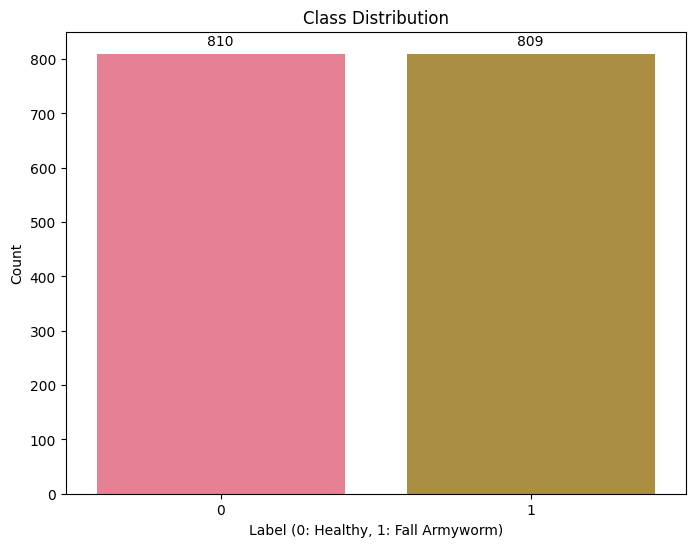

In [8]:
# Check class distribution
class_counts = train_df['Label'].value_counts().sort_index()
print("Class distribution:")
print(f"Class 0 (Healthy): {class_counts[0]} ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"Class 1 (Fall Armyworm): {class_counts[1]} ({class_counts[1]/len(train_df)*100:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='Label')
plt.title('Class Distribution')
plt.xlabel('Label (0: Healthy, 1: Fall Armyworm)')
plt.ylabel('Count')
for i, v in enumerate(class_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

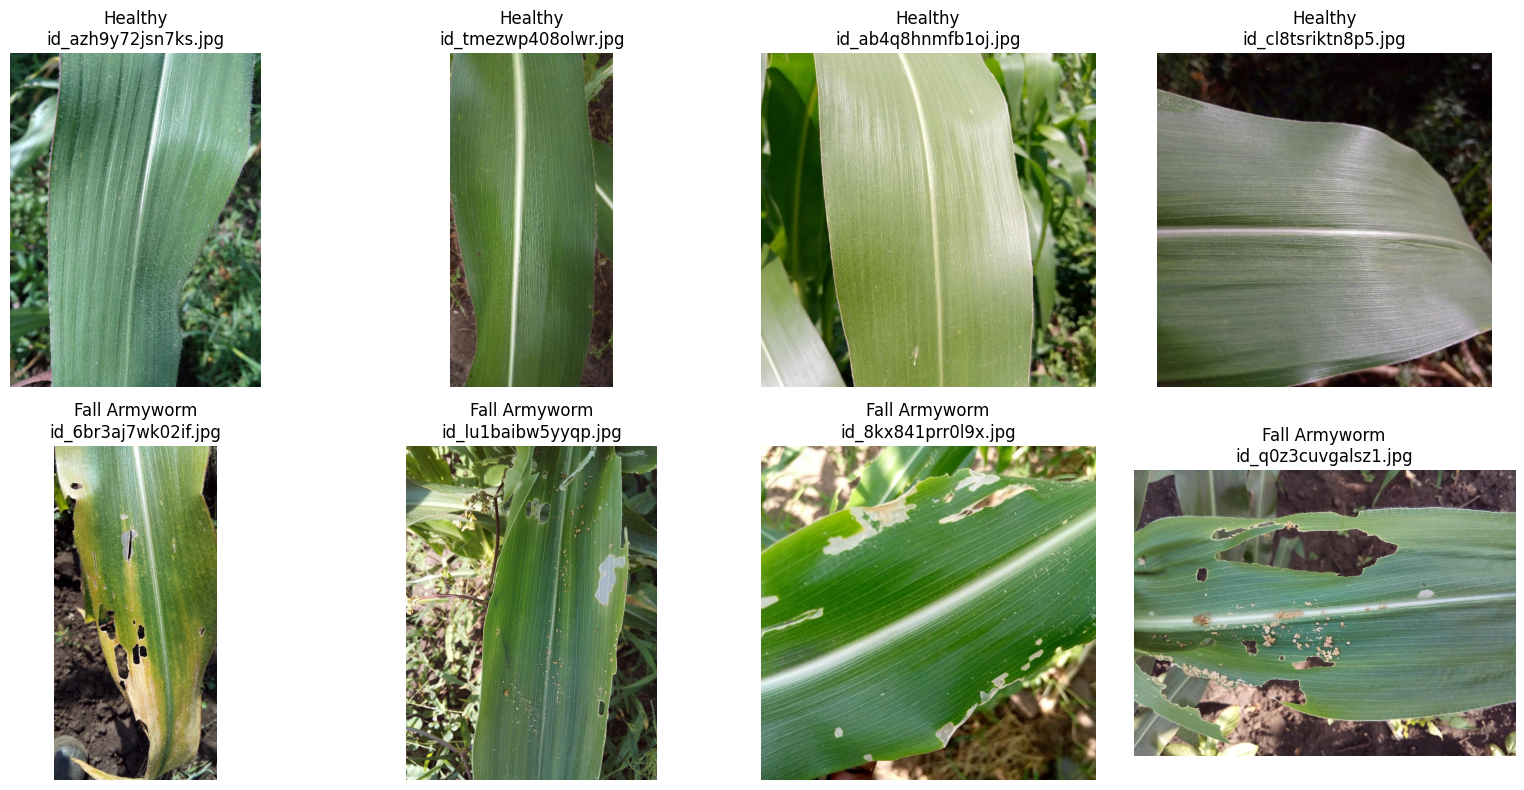

In [9]:
# Visualize sample images
def show_sample_images(df, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get samples from each class
    class_0_samples = df[df['Label'] == 0].sample(num_samples//2)
    class_1_samples = df[df['Label'] == 1].sample(num_samples//2)
    samples = pd.concat([class_0_samples, class_1_samples])
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(IMAGES_DIR, row['Image_id'])
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            label_text = "Healthy" if row['Label'] == 0 else "Fall Armyworm"
            axes[idx].set_title(f"{label_text}\n{row['Image_id']}")
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(train_df)

## 3. Custom Dataset Implementation

In [10]:
class MaizeLeafDataset(Dataset):
    def __init__(self, df, images_dir, transform=None, is_test=False):
        """
        Custom Dataset for Maize Leaf Classification
        
        Args:
            df: DataFrame containing image_id and labels
            images_dir: Directory containing images
            transform: Torchvision transforms to apply
            is_test: Whether this is test data (no labels)
        """
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image path
        img_id = self.df.iloc[idx]['Image_id']
        img_path = os.path.join(self.images_dir, img_id)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, img_id
        else:
            label = torch.tensor(self.df.iloc[idx]['Label'], dtype=torch.float32)
            return image, label

print("Custom Dataset class created successfully!")

Custom Dataset class created successfully!


## 4. Data Preprocessing and Augmentation

In [11]:
# Define image transformations
# ImageNet statistics for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms without augmentation
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Image transformations defined:")
print(f"- Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"- Normalization: ImageNet statistics")
print(f"- Augmentations: Horizontal flip, rotation, color jitter, affine")

Image transformations defined:
- Input size: 224x224
- Normalization: ImageNet statistics
- Augmentations: Horizontal flip, rotation, color jitter, affine


In [12]:
# Split training data into train and validation sets
train_data, val_data = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['Label']
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_df)}")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(train_data['Label'].value_counts().sort_index())
print("\nClass distribution in validation set:")
print(val_data['Label'].value_counts().sort_index())

Training samples: 1295
Validation samples: 324
Test samples: 1080

Class distribution in training set:
Label
0    648
1    647
Name: count, dtype: int64

Class distribution in validation set:
Label
0    162
1    162
Name: count, dtype: int64


In [13]:
# Create datasets and dataloaders
BATCH_SIZE = 32
NUM_WORKERS = 4 if os.name != 'nt' else 0  # Use 0 workers on Windows to avoid issues

# Create datasets
train_dataset = MaizeLeafDataset(train_data, IMAGES_DIR, transform=train_transforms)
val_dataset = MaizeLeafDataset(val_data, IMAGES_DIR, transform=val_transforms)
test_dataset = MaizeLeafDataset(test_df, IMAGES_DIR, transform=val_transforms, is_test=True)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoaders created with batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

DataLoaders created with batch size: 32
Train batches: 41
Val batches: 11
Test batches: 34


## 5. Model Definition and Transfer Learning

In [14]:
class MaizeLeafClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=1, pretrained=True):
        """
        Binary classifier for maize leaf classification using transfer learning
        
        Args:
            model_name: Name of the pretrained model to use
            num_classes: Number of output classes (1 for binary classification)
            pretrained: Whether to use pretrained weights
        """
        super(MaizeLeafClassifier, self).__init__()
        
        # Load pretrained model
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0  # Remove classifier head
        )
        
        # Get number of features from backbone
        num_features = self.backbone.num_features
        
        # Create custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # Extract features using backbone
        features = self.backbone(x)
        # Apply classifier
        output = self.classifier(features)
        return output

# Create model
model = MaizeLeafClassifier(model_name='efficientnet_b0', num_classes=1, pretrained=True)
model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: EfficientNet-B0 with custom classifier")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model moved to: {device}")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model: EfficientNet-B0 with custom classifier
Total parameters: 4,663,933
Trainable parameters: 4,663,933
Model moved to: cuda


In [15]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Training setup:")
print(f"- Loss function: BCEWithLogitsLoss")
print(f"- Optimizer: Adam (lr=1e-4, weight_decay=1e-4)")
print(f"- Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print("- Note: Scheduler will reduce LR by 50% when validation loss stops improving for 3 epochs")

Training setup:
- Loss function: BCEWithLogitsLoss
- Optimizer: Adam (lr=1e-4, weight_decay=1e-4)
- Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
- Note: Scheduler will reduce LR by 50% when validation loss stops improving for 3 epochs


## 6. Training and Validation Functions

In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
        auc: Training AUC
    """
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        images = images.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        
        # Convert to probabilities and predictions
        probs = torch.sigmoid(outputs)
        all_predictions.extend(probs.cpu().detach().numpy())
        all_targets.extend(targets.cpu().detach().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}'
        })
    
    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate accuracy
    predicted_classes = (all_predictions > 0.5).astype(int)
    accuracy = accuracy_score(all_targets, predicted_classes)
    
    # Calculate AUC
    auc = roc_auc_score(all_targets, all_predictions)
    
    return avg_loss, accuracy, auc

In [17]:
def validate(model, dataloader, criterion, device):
    """
    Validate the model
    
    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy
        auc: Validation AUC
    """
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    
    progress_bar = tqdm(dataloader, desc="Validation")
    
    with torch.no_grad():
        for images, targets in progress_bar:
            images = images.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            
            # Convert to probabilities
            probs = torch.sigmoid(outputs)
            all_predictions.extend(probs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}'
            })
    
    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate accuracy
    predicted_classes = (all_predictions > 0.5).astype(int)
    accuracy = accuracy_score(all_targets, predicted_classes)
    
    # Calculate AUC
    auc = roc_auc_score(all_targets, all_predictions)
    
    return avg_loss, accuracy, auc

In [18]:
def predict(model, dataloader, device):
    """
    Generate predictions for test data
    
    Returns:
        predictions: Array of predicted probabilities
        image_ids: List of image IDs
    """
    model.eval()
    predictions = []
    image_ids = []
    
    progress_bar = tqdm(dataloader, desc="Predicting")
    
    with torch.no_grad():
        for images, img_ids in progress_bar:
            images = images.to(device)
            
            # Forward pass
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            
            predictions.extend(probs.cpu().numpy())
            image_ids.extend(img_ids)
    
    return np.array(predictions), image_ids

print("Training, validation, and prediction functions defined!")

Training, validation, and prediction functions defined!


## 7. Training Loop with Early Stopping

In [19]:
# Training configuration
NUM_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'best_maize_leaf_model.pth')

# Initialize tracking variables
best_val_auc = 0.0
early_stopping_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_aucs = []
val_aucs = []

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")
print("=" * 60)

Starting training for 20 epochs...
Early stopping patience: 5
Model will be saved to: /kaggle/working/best_maize_leaf_model.pth


In [20]:
# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training phase
    train_loss, train_acc, train_auc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validation phase
    val_loss, val_acc, val_auc = validate(
        model, val_loader, criterion, device
    )
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    # Print epoch results
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_auc': best_val_auc,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'train_aucs': train_aucs,
            'val_aucs': val_aucs
        }, MODEL_SAVE_PATH)
        print(f"✓ New best model saved with Val AUC: {best_val_auc:.4f}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"✗ No improvement. Early stopping counter: {early_stopping_counter}/{EARLY_STOPPING_PATIENCE}")
    
    # Early stopping
    if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
        break

print(f"\nTraining completed!")
print(f"Best validation AUC: {best_val_auc:.4f}")


Epoch 1/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s, Loss=0.6446]



Epoch 1 Results:
Train Loss: 0.4586 | Train Acc: 0.8587 | Train AUC: 0.9535
Val Loss: 0.2241 | Val Acc: 0.9784 | Val AUC: 0.9981
Current LR: 0.000100
✓ New best model saved with Val AUC: 0.9981

Epoch 2/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s, Loss=0.4025]



Epoch 2 Results:
Train Loss: 0.1113 | Train Acc: 0.9761 | Train AUC: 0.9959
Val Loss: 0.0745 | Val Acc: 0.9877 | Val AUC: 0.9992
Current LR: 0.000100
✓ New best model saved with Val AUC: 0.9992

Epoch 3/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.94it/s, Loss=0.0982]



Epoch 3 Results:
Train Loss: 0.0345 | Train Acc: 0.9907 | Train AUC: 0.9993
Val Loss: 0.0460 | Val Acc: 0.9846 | Val AUC: 0.9994
Current LR: 0.000100
✓ New best model saved with Val AUC: 0.9994

Epoch 4/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.92it/s, Loss=0.1809]



Epoch 4 Results:
Train Loss: 0.0287 | Train Acc: 0.9923 | Train AUC: 0.9994
Val Loss: 0.0434 | Val Acc: 0.9877 | Val AUC: 0.9993
Current LR: 0.000100
✗ No improvement. Early stopping counter: 1/5

Epoch 5/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.89it/s, Loss=0.1768]



Epoch 5 Results:
Train Loss: 0.0267 | Train Acc: 0.9931 | Train AUC: 0.9998
Val Loss: 0.0366 | Val Acc: 0.9877 | Val AUC: 0.9997
Current LR: 0.000100
✓ New best model saved with Val AUC: 0.9997

Epoch 6/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s, Loss=0.3059]



Epoch 6 Results:
Train Loss: 0.0140 | Train Acc: 0.9954 | Train AUC: 0.9999
Val Loss: 0.0560 | Val Acc: 0.9846 | Val AUC: 0.9994
Current LR: 0.000100
✗ No improvement. Early stopping counter: 1/5

Epoch 7/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s, Loss=0.5589]



Epoch 7 Results:
Train Loss: 0.0157 | Train Acc: 0.9946 | Train AUC: 0.9998
Val Loss: 0.0676 | Val Acc: 0.9907 | Val AUC: 0.9996
Current LR: 0.000100
✗ No improvement. Early stopping counter: 2/5

Epoch 8/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.97it/s, Loss=0.1258]



Epoch 8 Results:
Train Loss: 0.0106 | Train Acc: 0.9969 | Train AUC: 0.9999
Val Loss: 0.0409 | Val Acc: 0.9846 | Val AUC: 0.9995
Current LR: 0.000100
✗ No improvement. Early stopping counter: 3/5

Epoch 9/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.89it/s, Loss=0.0536]



Epoch 9 Results:
Train Loss: 0.0183 | Train Acc: 0.9946 | Train AUC: 0.9999
Val Loss: 0.0293 | Val Acc: 0.9907 | Val AUC: 0.9995
Current LR: 0.000100
✗ No improvement. Early stopping counter: 4/5

Epoch 10/20
----------------------------------------


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s, Loss=0.0434]


Epoch 10 Results:
Train Loss: 0.0104 | Train Acc: 0.9977 | Train AUC: 1.0000
Val Loss: 0.0364 | Val Acc: 0.9815 | Val AUC: 0.9996
Current LR: 0.000100
✗ No improvement. Early stopping counter: 5/5

Early stopping triggered after 10 epochs!

Training completed!
Best validation AUC: 0.9997


## 8. Model Evaluation and Metrics

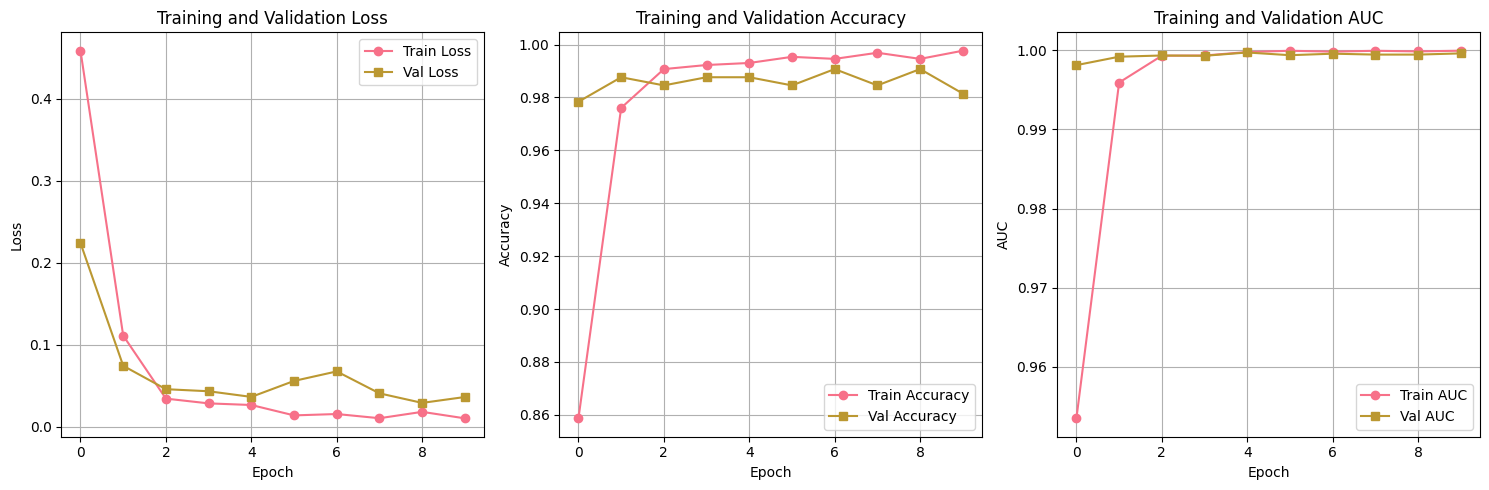

In [21]:
# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Val Accuracy', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', marker='o')
plt.plot(val_aucs, label='Val AUC', marker='s')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Load best model for final evaluation
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']}")
print(f"Best validation AUC: {checkpoint['best_val_auc']:.4f}")

# Final evaluation on validation set
final_val_loss, final_val_acc, final_val_auc = validate(model, val_loader, criterion, device)

print("\nFinal Model Performance on Validation Set:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_acc:.4f}")
print(f"AUC: {final_val_auc:.4f}")

Best model loaded from epoch 5
Best validation AUC: 0.9997


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s, Loss=0.1768]


Final Model Performance on Validation Set:
Loss: 0.0366
Accuracy: 0.9877
AUC: 0.9997


## 9. Test Set Inference

Generating predictions on test set...


Predicting: 100%|██████████| 34/34 [00:07<00:00,  4.33it/s]


Generated 1080 predictions
Prediction range: [0.0000, 1.0000]
Mean prediction: 0.5052


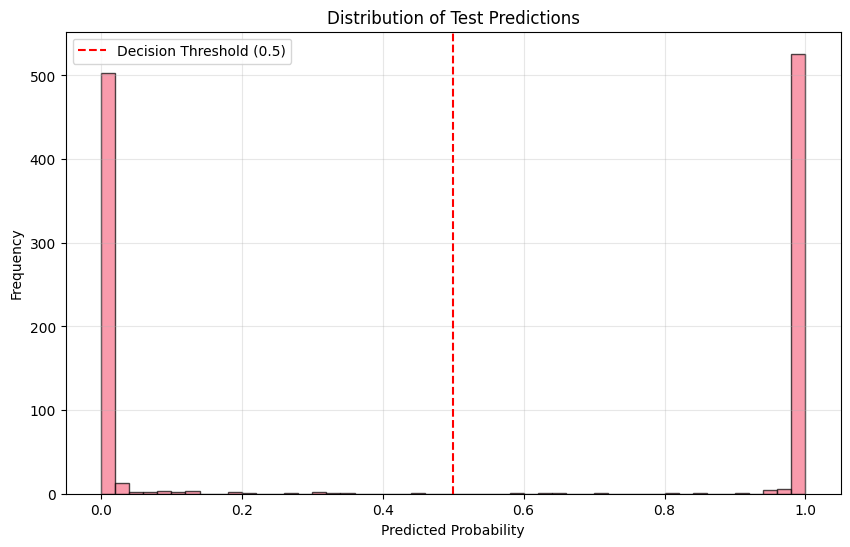


Predicted classes distribution:
Class 0 (Healthy): 537 (49.7%)
Class 1 (Fall Armyworm): 543 (50.3%)


In [24]:
# Generate predictions on test set
print("Generating predictions on test set...")
test_predictions, test_image_ids = predict(model, test_loader, device)

print(f"Generated {len(test_predictions)} predictions")
print(f"Prediction range: [{test_predictions.min():.4f}, {test_predictions.max():.4f}]")
print(f"Mean prediction: {test_predictions.mean():.4f}")

# Show distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(test_predictions, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Count predictions by class
predicted_classes = (test_predictions > 0.5).astype(int)
class_counts = np.bincount(predicted_classes)
print(f"\nPredicted classes distribution:")
print(f"Class 0 (Healthy): {class_counts[0]} ({class_counts[0]/len(predicted_classes)*100:.1f}%)")
print(f"Class 1 (Fall Armyworm): {class_counts[1]} ({class_counts[1]/len(predicted_classes)*100:.1f}%)")

## 10. Submission File Creation

In [25]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'Image_id': test_image_ids,
    'Label': test_predictions
})

# Verify submission format matches sample
print("Submission format check:")
print(f"Submission shape: {submission_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"Columns match: {list(submission_df.columns) == list(sample_sub.columns)}")

# Check for missing images
sample_ids = set(sample_sub['Image_id'])
submission_ids = set(submission_df['Image_id'])
missing_ids = sample_ids - submission_ids
extra_ids = submission_ids - sample_ids

print(f"Missing images: {len(missing_ids)}")
print(f"Extra images: {len(extra_ids)}")

if missing_ids:
    print(f"Missing image IDs: {list(missing_ids)[:10]}...")
if extra_ids:
    print(f"Extra image IDs: {list(extra_ids)[:10]}...")

# Display first few rows
print("\nSubmission preview:")
print(submission_df.head(10))

Submission format check:
Submission shape: (1080, 2)
Sample submission shape: (1080, 2)
Columns match: True
Missing images: 0
Extra images: 0

Submission preview:
               Image_id     Label
0  id_00exusbkgzw1b.jpg  0.003146
1  id_03dqinf6w0znv.jpg  0.000877
2  id_046yl0cxn3ybz.jpg  0.999743
3  id_04athdtx2abyg.jpg  0.000758
4  id_062aauf9e9jk0.jpg  0.007550
5  id_0695b3b665yet.jpg  0.000410
6  id_06cueqs5yhekm.jpg  0.999992
7  id_0826dbdkr8sxr.jpg  0.999701
8  id_09re5drh85tbo.jpg  0.000228
9  id_0adud1myz8tvz.jpg  0.039297


In [26]:
# Save submission file in Kaggle working directory
submission_filename = os.path.join(OUTPUT_DIR, 'submission.csv')
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as: {submission_filename}")
print(f"File size: {os.path.getsize(submission_filename) / 1024:.2f} KB")

# Final verification
saved_df = pd.read_csv(submission_filename)
print(f"\nVerification - Saved file shape: {saved_df.shape}")
print(f"Label range: [{saved_df['Label'].min():.4f}, {saved_df['Label'].max():.4f}]")
print(f"No missing values: {saved_df.isnull().sum().sum() == 0}")

print("\n" + "="*60)
print("🎉 SUBMISSION READY FOR KAGGLE! 🎉")
print("="*60)
print(f"Model: EfficientNet-B0 with transfer learning")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Submission file: {submission_filename}")
print(f"Model saved at: {MODEL_SAVE_PATH}")
print(f"Predictions: Probabilities (0-1 range)")
print("="*60)

Submission file saved as: /kaggle/working/submission.csv
File size: 34.35 KB

Verification - Saved file shape: (1080, 2)
Label range: [0.0000, 1.0000]
No missing values: True

🎉 SUBMISSION READY FOR KAGGLE! 🎉
Model: EfficientNet-B0 with transfer learning
Best Validation AUC: 0.9997
Submission file: /kaggle/working/submission.csv
Model saved at: /kaggle/working/best_maize_leaf_model.pth
Predictions: Probabilities (0-1 range)


In [28]:
# Show all files created in the output directory
print("\n" + "="*60)
print("📁 FILES CREATED IN OUTPUT DIRECTORY")
print("="*60)

if os.path.exists(OUTPUT_DIR):
    output_files = os.listdir(OUTPUT_DIR)
    if output_files:
        for file in output_files:
            file_path = os.path.join(OUTPUT_DIR, file)
            file_size = os.path.getsize(file_path) / 1024  # Size in KB
            print(f"📄 {file} ({file_size:.2f} KB)")
    else:
        print("No files found in output directory")
else:
    print("Output directory not found")

print("\n🚀 Ready to submit to Kaggle!")
print("📋 Next steps:")
print("1. Download the submission.csv file")
print("2. Submit to the competition")
print("3. Optionally download the model file for future use")


📁 FILES CREATED IN OUTPUT DIRECTORY
📄 .virtual_documents (4.00 KB)
📄 best_maize_leaf_model.pth (55141.54 KB)
📄 submission.csv (34.35 KB)

🚀 Ready to submit to Kaggle!
📋 Next steps:
1. Download the submission.csv file
2. Submit to the competition
3. Optionally download the model file for future use
